In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from datetime import datetime
import os

In [ ]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    
    if "closed" in ride_data.columns:
        if ride_data["closed"].dtype == bool:
            ride_data["closed"] = ride_data["closed"].astype(int)
        else:
            ride_data["closed"] = ride_data["closed"].astype(bool).astype(int)
    
    if ride_data['timestamp'].duplicated().any():
        print(f"Warning: Found {ride_data['timestamp'].duplicated().sum()} duplicate timestamps. Keeping first occurrence.")
        ride_data = ride_data[~ride_data['timestamp'].duplicated(keep='first')]
    
    try:
        ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    except Exception as e:
        print(f"Error during resampling: {e}")
        print("Using alternative approach to handle resampling...")
        
        ride_data['timestamp_rounded'] = ride_data['timestamp'].dt.floor('30min')
        numeric_cols = ride_data.select_dtypes(include=['number']).columns
        
        non_numeric_cols = [col for col in ride_data.columns 
                           if col not in numeric_cols and col != 'timestamp']

        agg_dict = {col: 'mean' for col in numeric_cols}
        for col in non_numeric_cols:
            agg_dict[col] = 'first'

        ride_data = ride_data.groupby('timestamp_rounded').agg(agg_dict).reset_index()
        ride_data.rename(columns={'timestamp_rounded': 'timestamp'}, inplace=True)

    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]

    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()

    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour

    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)

    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])

    def is_operating_hour(timestamp):
        date = timestamp.date()
        if date not in date_to_hours:
            return 0
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [ ]:
def create_binned_time_features(df):
    """Create binned time features and other relevant features."""
    df = df.copy()
    df['hour'] = df['timestamp'].dt.hour

    conditions = [
        (df['hour'] >= 6) & (df['hour'] < 9),
        (df['hour'] >= 9) & (df['hour'] < 12),
        (df['hour'] >= 12) & (df['hour'] < 15),
        (df['hour'] >= 15) & (df['hour'] < 18),
        (df['hour'] >= 18) & (df['hour'] < 21),
        (df['hour'] >= 21) | (df['hour'] < 6)
    ]
    
    time_bins = [
        'early_morning',
        'late_morning',
        'early_afternoon',
        'late_afternoon',
        'early_evening',
        'night'
    ]
    
    df['time_of_day_bin'] = np.select(conditions, time_bins, default='other')
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['month'] = df['timestamp'].dt.month

    conditions = [
        (df['month'] >= 3) & (df['month'] <= 5),
        (df['month'] >= 6) & (df['month'] <= 8),
        (df['month'] >= 9) & (df['month'] <= 11),
        (df['month'] == 12) | (df['month'] <= 2)
    ]
    
    seasons = ['spring', 'summer', 'fall', 'winter']
    df['season'] = np.select(conditions, seasons, default='unknown')
    
    holiday_cols = ['is_german_holiday', 'is_swiss_holiday', 'is_french_holiday']
    existing_holiday_cols = [col for col in holiday_cols if col in df.columns]
    
    if existing_holiday_cols:
        df['is_any_holiday'] = df[existing_holiday_cols].max(axis=1)
        df['holiday_weekend'] = df['is_any_holiday'] * df['is_weekend']
    else:
        df['is_any_holiday'] = 0
        df['holiday_weekend'] = 0

    if 'temperature' in df.columns:
        bins = [0, 10, 20, 30, 100]
        labels = ['cold', 'mild', 'warm', 'hot']
        df['temp_bin'] = pd.cut(df['temperature'], bins=bins, labels=labels)
    
    if 'rain' in df.columns:
        df['has_rain'] = (df['rain'] > 0).astype(int)
    
    return df

In [76]:
def split_data_by_time(df, test_year=2023):
    """Split data into training and test sets based on year."""
    train_df = df[df['timestamp'].dt.year < test_year].copy()
    test_df = df[df['timestamp'].dt.year == test_year].copy()
    
    print(f"Training data: {len(train_df)} rows from {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
    print(f"Test data: {len(test_df)} rows from {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")
    
    return train_df, test_df

In [ ]:
def prepare_features_for_linear_model(df):
    """Prepare features for the linear model."""
    categorical_features = ['time_of_day_bin', 'season', 'day_of_week']

    if 'temp_bin' in df.columns:
        categorical_features.append('temp_bin')
    
    numerical_features = ['is_weekend', 'is_any_holiday', 'holiday_weekend']

    if 'temperature' in df.columns:
        numerical_features.append('temperature')
    if 'rain' in df.columns:
        numerical_features.append('rain')
    if 'wind' in df.columns:
        numerical_features.append('wind')
    if 'has_rain' in df.columns:
        numerical_features.append('has_rain')
    if 'closed' in df.columns:
        numerical_features.append('closed')

    feature_df = df[categorical_features + numerical_features].copy()

    null_counts = feature_df.isnull().sum()
    if null_counts.sum() > 0:
        print("Warning: Missing values detected in features:")
        print(null_counts[null_counts > 0])

        for col in numerical_features:
            if col in feature_df.columns and feature_df[col].isnull().sum() > 0:
                feature_df[col] = feature_df[col].fillna(feature_df[col].median())

        for col in categorical_features:
            if col in feature_df.columns and feature_df[col].isnull().sum() > 0:
                feature_df[col] = feature_df[col].fillna(feature_df[col].mode()[0])
    
    return feature_df, categorical_features, numerical_features

In [ ]:
def build_and_train_linear_model(X_train, y_train, categorical_features, numerical_features):
    """Build and train a linear regression model with preprocessing pipeline."""
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ]
    )

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    model.fit(X_train, y_train)
    
    return model

In [ ]:
def evaluate_model(model, X_test, y_test, feature_names=None):
    """Evaluate the linear regression model and print coefficients."""
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    print(f"R² Score: {r2:.4f}")

    epsilon = 1e-8
    abs_pct_errors = np.abs(y_test - y_pred) / (np.abs(y_test) + epsilon)
    non_zero_mask = y_test > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    if feature_names is not None:
        print("\nFeature Importance (Coefficients):")
        try:
            linear_model = model.named_steps['regressor']
            preprocessor = model.named_steps['preprocessor']

            if hasattr(preprocessor, 'get_feature_names_out'):
                feature_names = preprocessor.get_feature_names_out()

            coefficients = pd.DataFrame(
                linear_model.coef_,
                index=feature_names,
                columns=['Coefficient']
            ).sort_values('Coefficient', ascending=False)

            print("\nTop 10 Positive Coefficients:")
            print(coefficients.head(10))
            
            print("\nTop 10 Negative Coefficients:")
            print(coefficients.tail(10))
        except Exception as e:
            print(f"Could not print coefficients: {e}")
    
    return mae, rmse, r2, mape, y_pred

In [ ]:
def visualize_results(y_test, y_pred, ride_data_test):
    """Visualize the prediction results."""
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_pred - y_test,
        'Timestamp': ride_data_test['timestamp'].values
    })

    fig, axes = plt.subplots(2, 1, figsize=(14, 12))

    axes[0].scatter(results_df['Actual'], results_df['Predicted'], alpha=0.5)
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    axes[0].plot([0, max_val], [0, max_val], 'r--')
    axes[0].set_xlabel('Actual Wait Time (minutes)')
    axes[0].set_ylabel('Predicted Wait Time (minutes)')
    axes[0].set_title('Actual vs Predicted Wait Times')
    axes[0].grid(True, linestyle=':')

    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}"
    axes[0].text(0.05, 0.95, metrics_text, transform=axes[0].transAxes, 
                 verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    results_df = results_df.sort_values('Timestamp')
    axes[1].plot(results_df['Timestamp'], results_df['Actual'], label='Actual', alpha=0.7)
    axes[1].plot(results_df['Timestamp'], results_df['Predicted'], label='Predicted', alpha=0.7)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Wait Time (minutes)')
    axes[1].set_title('Actual vs Predicted Wait Times Over Time')
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    if 'hour' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['hour'] = ride_data_test['timestamp'].dt.hour

    if 'hour' in ride_data_test.columns:
        results_df['hour'] = ride_data_test['hour'].values

        hourly_errors = results_df.groupby('hour')['Error'].mean()

        if not hourly_errors.empty:
            plt.figure(figsize=(12, 6))
            hourly_errors.plot(kind='bar')
            plt.xlabel('Hour of Day')
            plt.ylabel('Mean Error (minutes)')
            plt.title('Mean Prediction Error by Hour of Day')
            plt.grid(True, linestyle=':')
            plt.tight_layout()
            plt.show()
    
    if 'day_of_week' not in ride_data_test.columns and hasattr(ride_data_test['timestamp'], 'dt'):
        ride_data_test = ride_data_test.copy()
        ride_data_test['day_of_week'] = ride_data_test['timestamp'].dt.dayofweek

    if 'day_of_week' in ride_data_test.columns:
        results_df['day'] = ride_data_test['day_of_week'].values
        daily_errors = results_df.groupby('day')['Error'].mean()

        if not daily_errors.empty:
            days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            plt.figure(figsize=(12, 6))
            daily_errors.plot(kind='bar')
            plt.xlabel('Day of Week')
            plt.ylabel('Mean Error (minutes)')
            plt.title('Mean Prediction Error by Day of Week')
            plt.xticks(range(len(days)), days)
            plt.grid(True, linestyle=':')
            plt.tight_layout()
            plt.show()

In [ ]:
def train_evaluate_linear_model(ride_name, data_path, test_year=2023):
    """Train and evaluate a linear model for ride wait time prediction."""
    print(f"Processing ride: {ride_name}")
    ride_df = load_ride_data(data_path, ride_name)
    print(f"Initial data size: {len(ride_df)}")
    
    ride_df = remove_closed_and_zero_wait_days(ride_df)
    print(f"After removing closed and zero wait days: {len(ride_df)}")

    ride_df = filter_to_operating_hours(ride_df)
    print(f"After filtering to operating hours: {len(ride_df)}")

    null_wait_times = ride_df['wait_time'].isnull().sum()
    if null_wait_times > 0:
        print(f"Found {null_wait_times} null wait times. Removing these rows.")
        ride_df = ride_df.dropna(subset=['wait_time'])
        print(f"After removing null wait times: {len(ride_df)}")

    ride_df = create_binned_time_features(ride_df)
    ride_train_df, ride_test_df = split_data_by_time(ride_df, test_year)

    X_train_df, categorical_features, numerical_features = prepare_features_for_linear_model(ride_train_df)
    X_test_df, _, _ = prepare_features_for_linear_model(ride_test_df)

    y_train = ride_train_df['wait_time'].values
    y_test = ride_test_df['wait_time'].values

    if np.isnan(y_train).any():
        print(f"Warning: {np.isnan(y_train).sum()} NaN values found in y_train. Removing these rows.")
        valid_indices = ~np.isnan(y_train)
        y_train = y_train[valid_indices]
        X_train_df = X_train_df.iloc[valid_indices]
    
    if np.isnan(y_test).any():
        print(f"Warning: {np.isnan(y_test).sum()} NaN values found in y_test. Removing these rows.")
        valid_indices = ~np.isnan(y_test)
        y_test = y_test[valid_indices]
        X_test_df = X_test_df.iloc[valid_indices]
        ride_test_df = ride_test_df.iloc[valid_indices].reset_index(drop=True)

    print("\nTraining the linear model...")
    model = build_and_train_linear_model(X_train_df, y_train, categorical_features, numerical_features)

    print("\nEvaluating the model on test data...")
    mae, rmse, r2, mape, y_pred = evaluate_model(model, X_test_df, y_test)

    visualize_results(y_test, y_pred, ride_test_df)

    return model, ride_df, ride_train_df, ride_test_df, y_pred, categorical_features, numerical_features

Processing ride: silver star
Initial data size: 103081
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
After removing closed and zero wait days: 85561
After filtering to operating hours: 30240
Found 1256 null wait times. Removing these rows.
After removing null wait times: 28984
Training data: 21421 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Test data: 4018 rows from 2023-04-01 09:30:00 to 2023-12-31 13:30:00
temp_bin        262
temperature     143
rain           4297
wind            368
dtype: int64
temp_bin       23
temperature    10
rain         

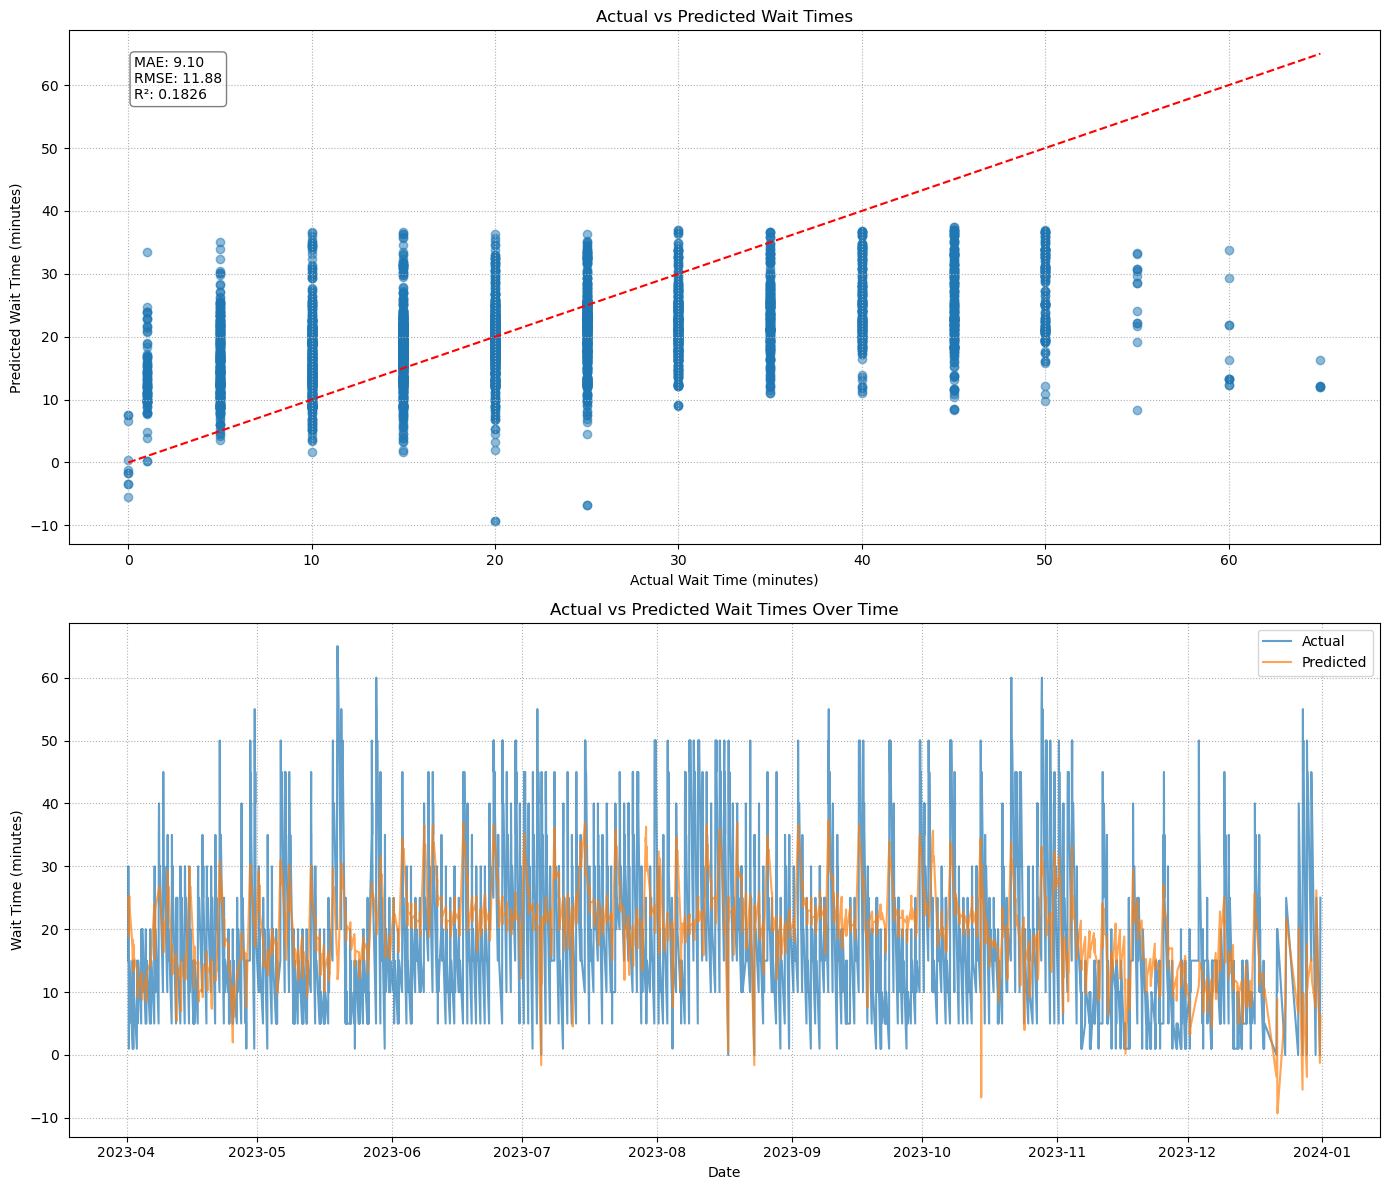

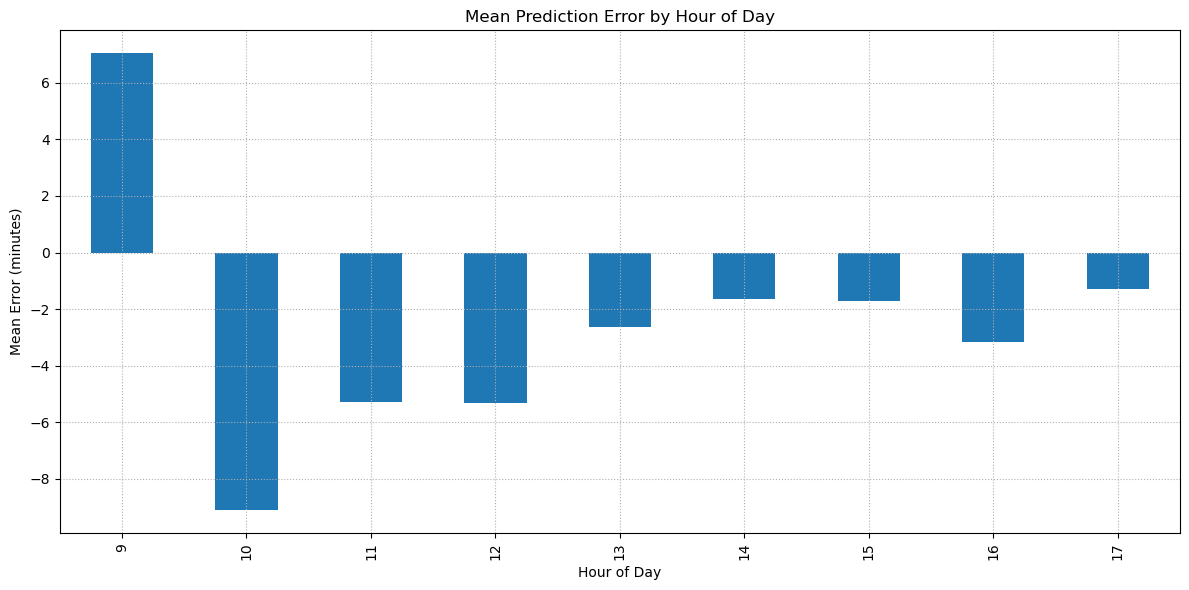

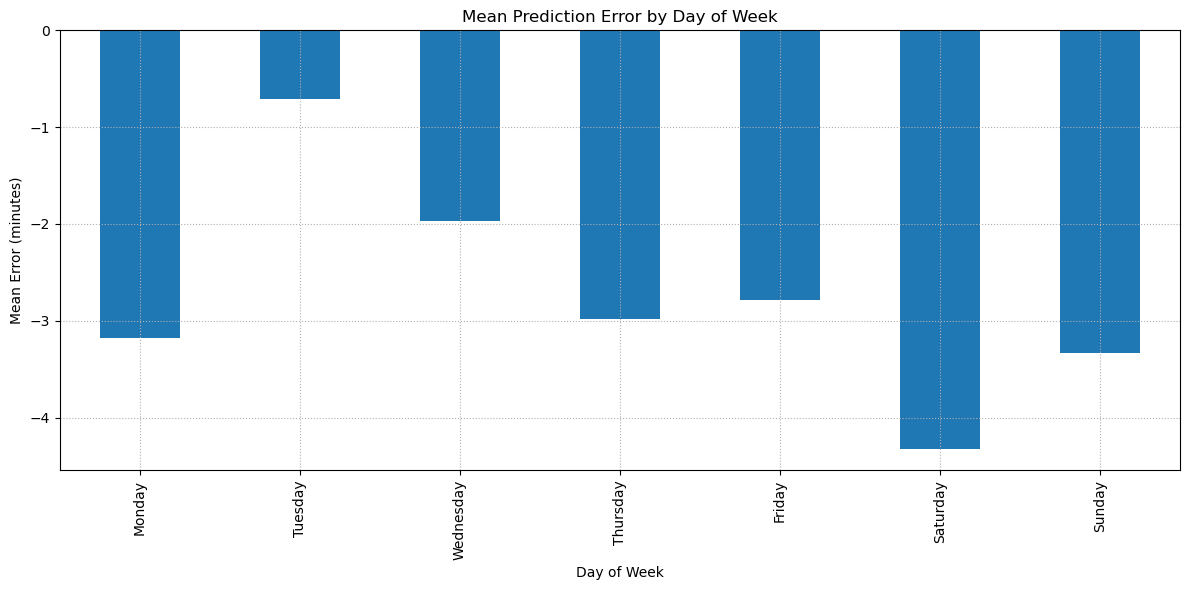

In [ ]:
data_path = "../data/processed/ep/merged_with_holidays.parquet"
ride_name = "silver star"

model, ride_df, ride_train_df, ride_test_df, predictions, categorical_features, numerical_features = train_evaluate_linear_model(
    ride_name, 
    data_path, 
    test_year=2023
)

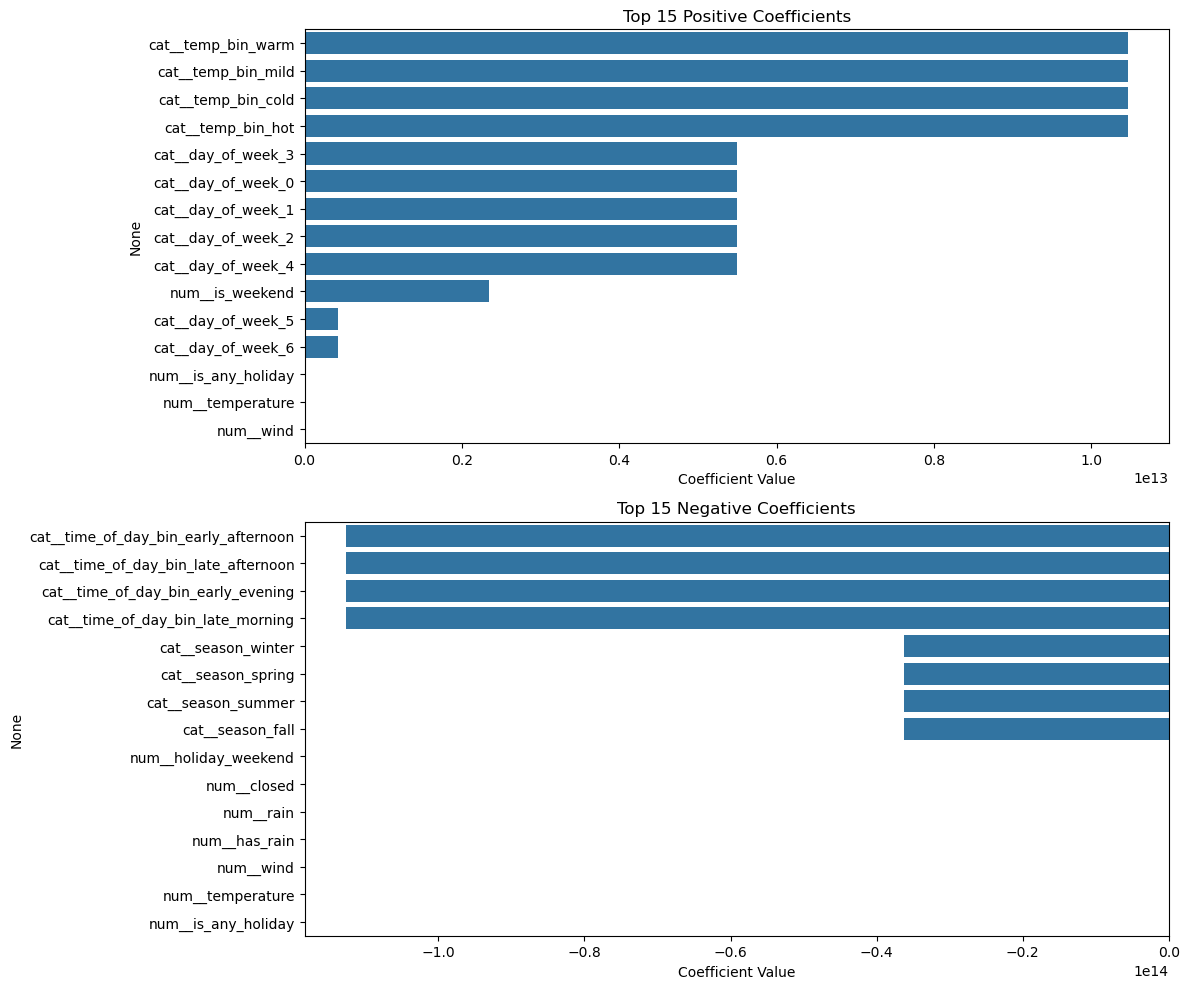

In [ ]:
def analyze_feature_importance(model, categorical_features, numerical_features):
    """Analyze and visualize feature importance."""
    try:
        linear_model = model.named_steps['regressor']
        preprocessor = model.named_steps['preprocessor']

        if hasattr(preprocessor, 'get_feature_names_out'):
            feature_names = preprocessor.get_feature_names_out()

        coefficients = pd.DataFrame(
            linear_model.coef_,
            index=feature_names,
            columns=['Coefficient']
        ).sort_values('Coefficient', ascending=False)

        plt.figure(figsize=(12, 10))

        top_positive = coefficients.head(15)
        plt.subplot(2, 1, 1)
        sns.barplot(x=top_positive['Coefficient'], y=top_positive.index)
        plt.title('Top 15 Positive Coefficients')
        plt.xlabel('Coefficient Value')
        plt.tight_layout()

        top_negative = coefficients.tail(15).iloc[::-1]
        plt.subplot(2, 1, 2)
        sns.barplot(x=top_negative['Coefficient'], y=top_negative.index)
        plt.title('Top 15 Negative Coefficients')
        plt.xlabel('Coefficient Value')
        plt.tight_layout()
        
        plt.show()
        
        return coefficients
    except Exception as e:
        print(f"Could not analyze feature importance: {e}")
        return None

feature_importance = analyze_feature_importance(model, categorical_features, numerical_features)

In [ ]:
def analyze_predictions_by_time_bin(ride_test_df, y_test, y_pred):
    """Analyze predictions by time of day bin."""
    results_df = pd.DataFrame({
        'time_of_day_bin': ride_test_df['time_of_day_bin'],
        'actual': y_test,
        'predicted': y_pred,
        'error': y_pred - y_test,
        'abs_error': np.abs(y_pred - y_test)
    })

    expected_bins = ['early_morning', 'late_morning', 'early_afternoon', 
                    'late_afternoon', 'early_evening', 'night']

    time_bin_metrics = results_df.groupby('time_of_day_bin', as_index=False).agg({
        'actual': 'mean',
        'predicted': 'mean',
        'error': 'mean',
        'abs_error': 'mean',
        'time_of_day_bin': 'count'
    }).rename(columns={'time_of_day_bin': 'bin', 'time_of_day_bin_count': 'count'})

    time_bin_metrics['mape'] = (time_bin_metrics['abs_error'] / time_bin_metrics['actual']) * 100

    time_bin_metrics['bin'] = pd.Categorical(
        time_bin_metrics['bin'], 
        categories=expected_bins,
        ordered=True
    )

    time_bin_metrics = time_bin_metrics.sort_values('bin')

    print("Performance by Time of Day Bin:")
    display(time_bin_metrics)

    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    x = np.arange(len(time_bin_metrics))
    
    plt.bar(x - bar_width/2, time_bin_metrics['actual'], bar_width, label='Actual')
    plt.bar(x + bar_width/2, time_bin_metrics['predicted'], bar_width, label='Predicted')
    
    plt.xlabel('Time of Day Bin')
    plt.ylabel('Average Wait Time (minutes)')
    plt.title('Actual vs Predicted Wait Times by Time of Day Bin')
    plt.xticks(x, time_bin_metrics['bin'], rotation=45)
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.bar(time_bin_metrics['bin'], time_bin_metrics['abs_error'])
    plt.xlabel('Time of Day Bin')
    plt.ylabel('Mean Absolute Error (minutes)')
    plt.title('Mean Absolute Error by Time of Day Bin')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle=':')
    plt.tight_layout()
    plt.show()
    
    return time_bin_metrics

In [ ]:
def save_model(model, ride_name, metadata, output_dir="models/linear"):
    """Save the trained model and metadata."""
    import pickle
    import json
    from datetime import datetime

    ride_dir = os.path.join(output_dir, ride_name.replace(" ", "_"))
    os.makedirs(ride_dir, exist_ok=True)

    model_path = os.path.join(ride_dir, "linear_model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    metadata_path = os.path.join(ride_dir, "metadata.json")

    if not metadata:
        metadata = {}
    
    metadata["saved_at"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    metadata["model_type"] = "linear_regression"
    
    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=4)
    
    print(f"Model and metadata saved to {ride_dir}")

metadata = {
    "ride_name": ride_name,
    "data_path": data_path,
    "train_size": len(ride_train_df),
    "test_size": len(ride_test_df),
    "metrics": {
        "mae": float(mean_absolute_error(ride_test_df['wait_time'], predictions)),
        "rmse": float(np.sqrt(mean_squared_error(ride_test_df['wait_time'], predictions))),
        "r2": float(r2_score(ride_test_df['wait_time'], predictions))
    }
}

# Save the model
save_model(model, ride_name, metadata)

Model and metadata saved to models/linear\silver_star



Processing ride: silver star
Processing ride: silver star
Initial data size: 103081
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')
After removing closed and zero wait days: 85561
After filtering to operating hours: 30240
Found 1256 null wait times. Removing these rows.
After removing null wait times: 28984
Training data: 21421 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Test data: 4018 rows from 2023-04-01 09:30:00 to 2023-12-31 13:30:00
temp_bin        262
temperature     143
rain           4297
wind            368
dtype: int64
temp_bin       23
t

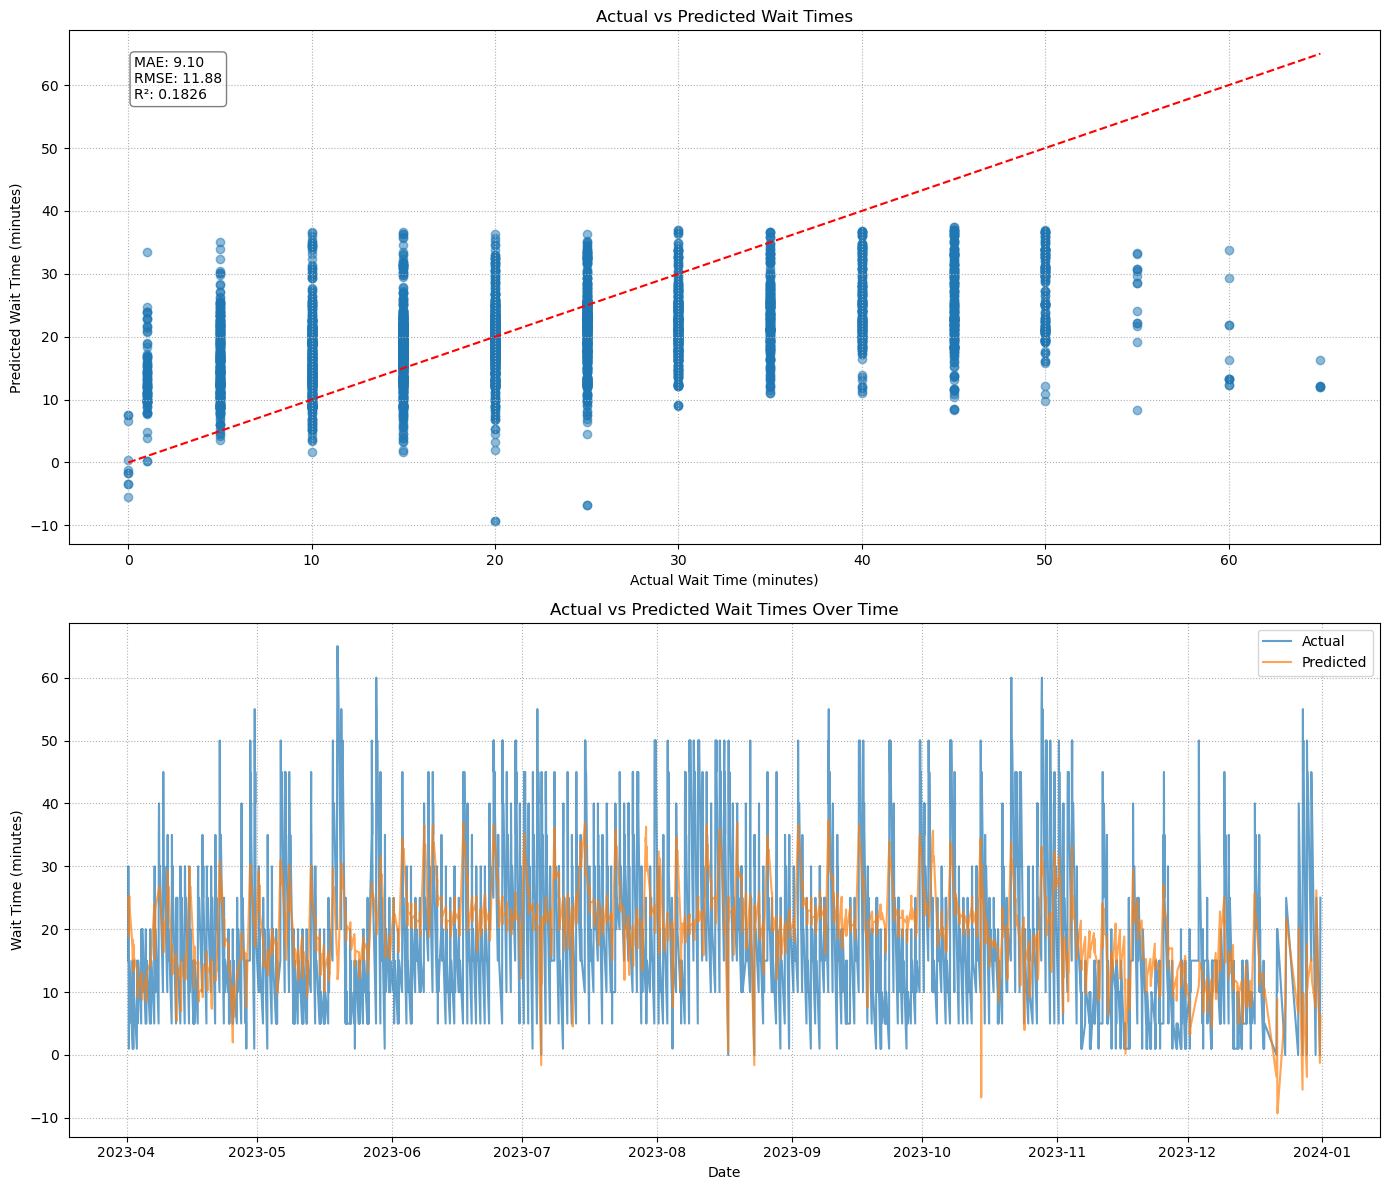

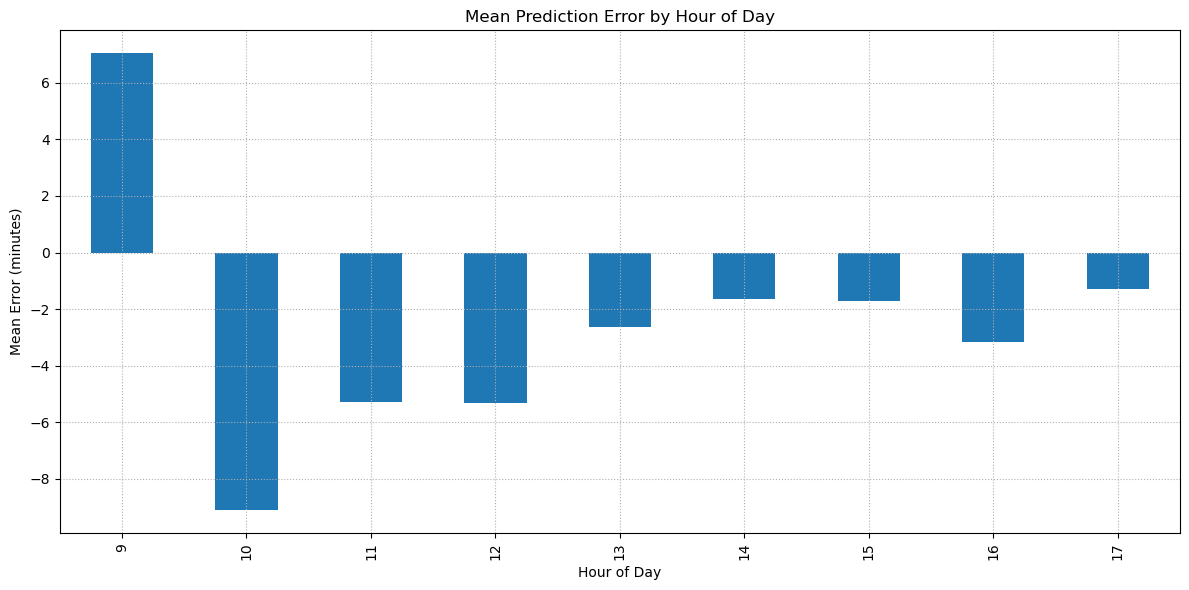

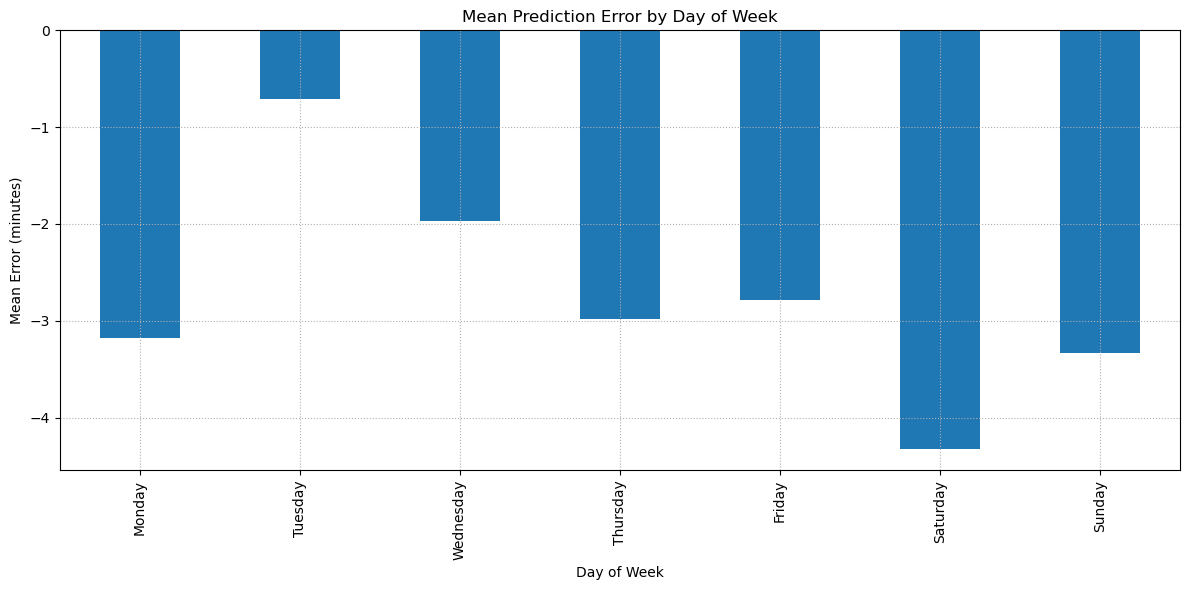

Model and metadata saved to models/linear\silver_star

Processing ride: eurosat
Processing ride: eurosat
Error during resampling: cannot insert timestamp, already exists
Using alternative approach to handle resampling...
Error processing ride eurosat: cannot insert timestamp_rounded, already exists

Processing ride: blue fire megacoaster
Processing ride: blue fire megacoaster
Initial data size: 103081
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 81
Sample of zero wait time days: Index([2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30, 2017-12-05, 2017-12-06,
       2017-12-07, 2017-12-11, 2017-12-12, 2017-12-14],
      dtype='object', name='timestamp')
After removing closed and zero wait days: 85609
After filtering to operating hours: 30274
Found 1417 null wait t

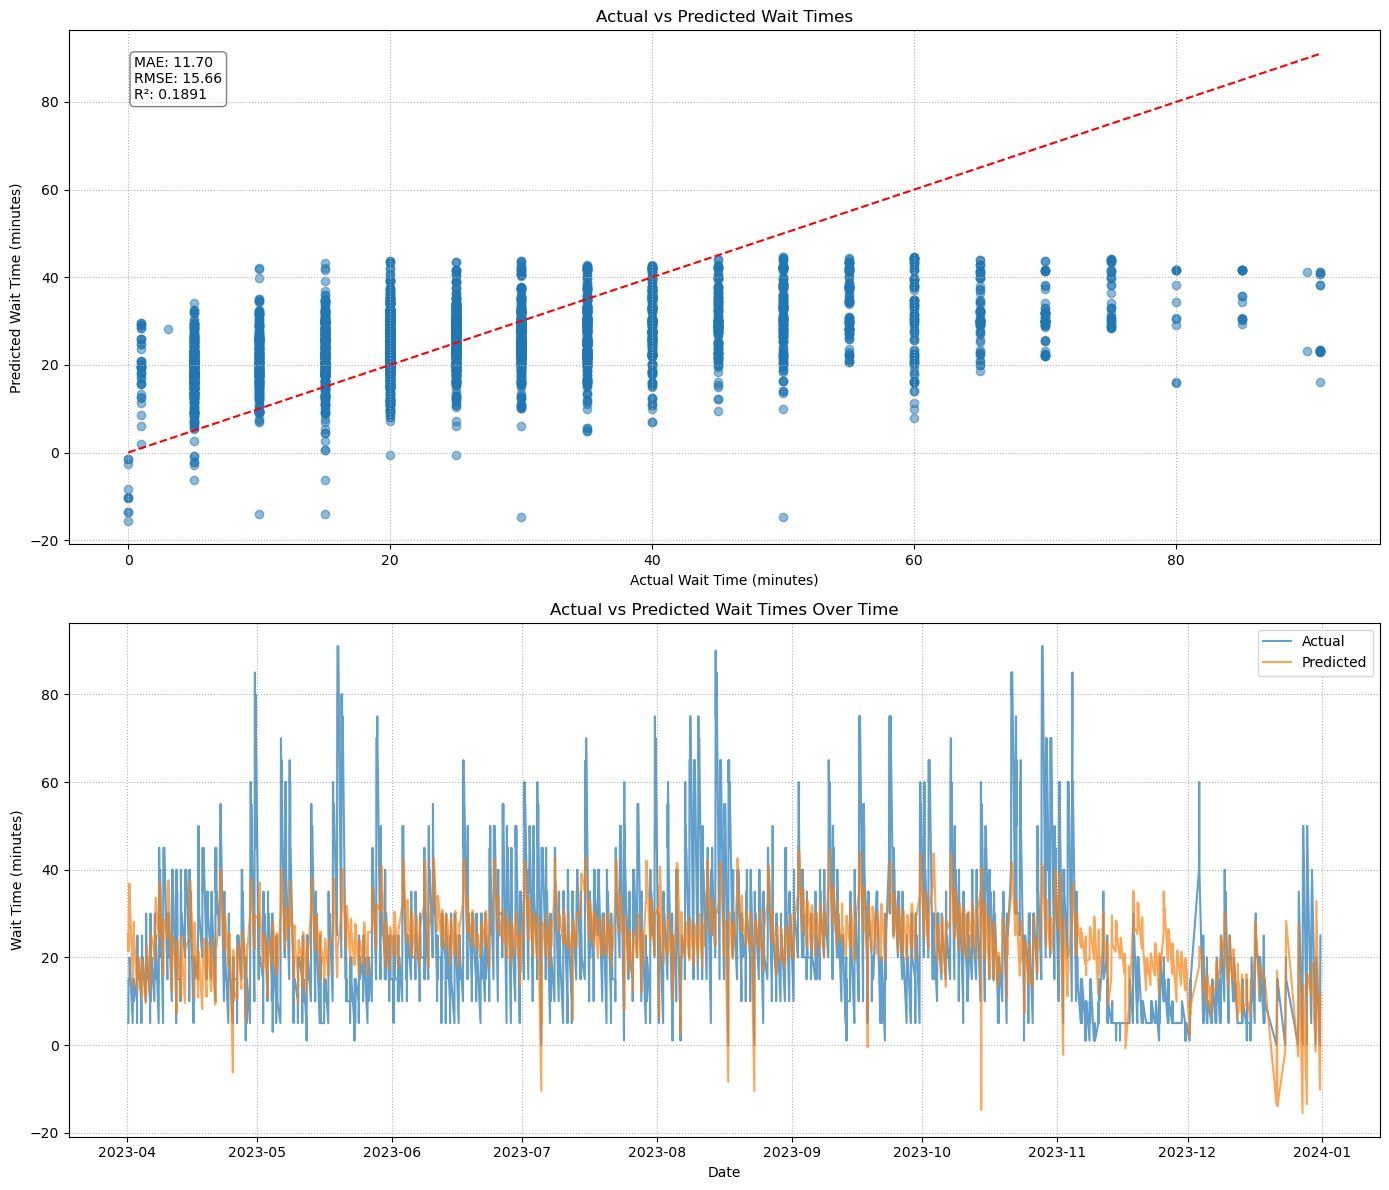

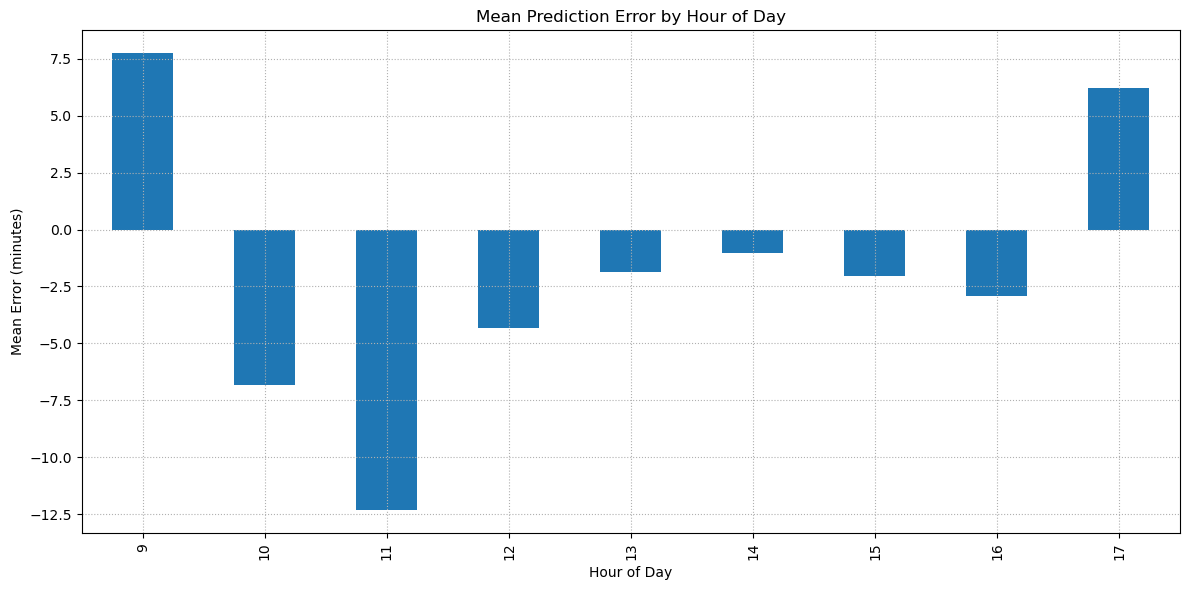

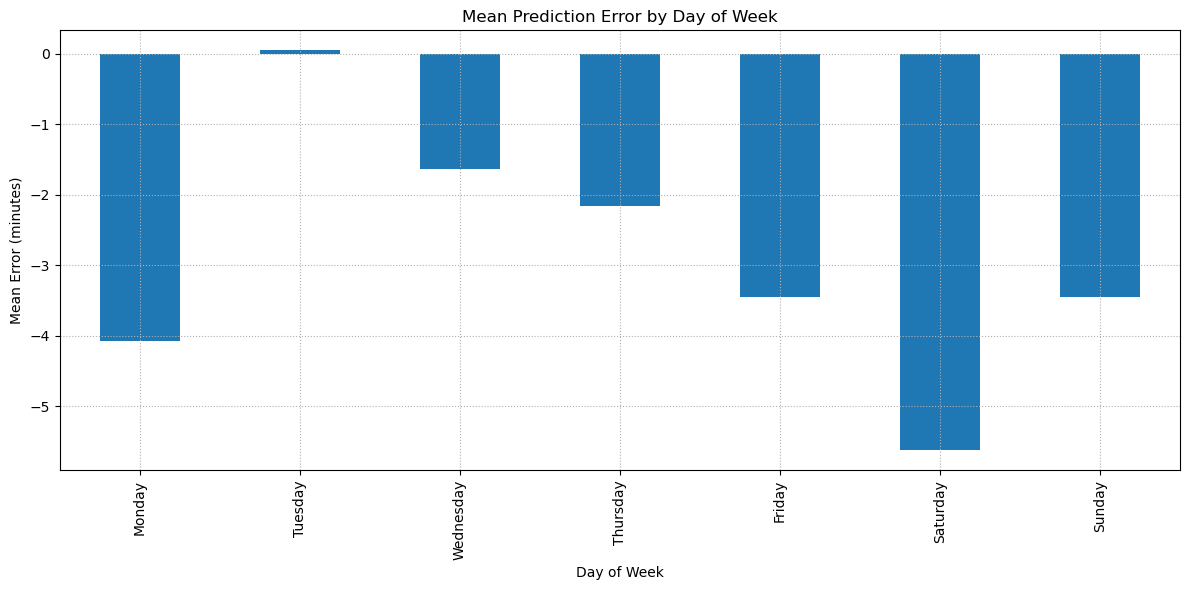

Model and metadata saved to models/linear\blue_fire_megacoaster

Processing ride: poseidon
Processing ride: poseidon
Initial data size: 103081
Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 593
Sample of zero wait time days: Index([2017-06-06, 2017-08-31, 2017-09-12, 2017-09-13, 2017-09-14, 2017-09-19,
       2017-09-20, 2017-10-06, 2017-10-08, 2017-10-23],
      dtype='object', name='timestamp')
After removing closed and zero wait days: 61038
After filtering to operating hours: 22148
Found 843 null wait times. Removing these rows.
After removing null wait times: 21305
Training data: 16213 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Test data: 2893 rows from 2023-04-06 09:30:00 to 2023-12-27 15:30:00
temp_bin         93
temperature      93
rain          

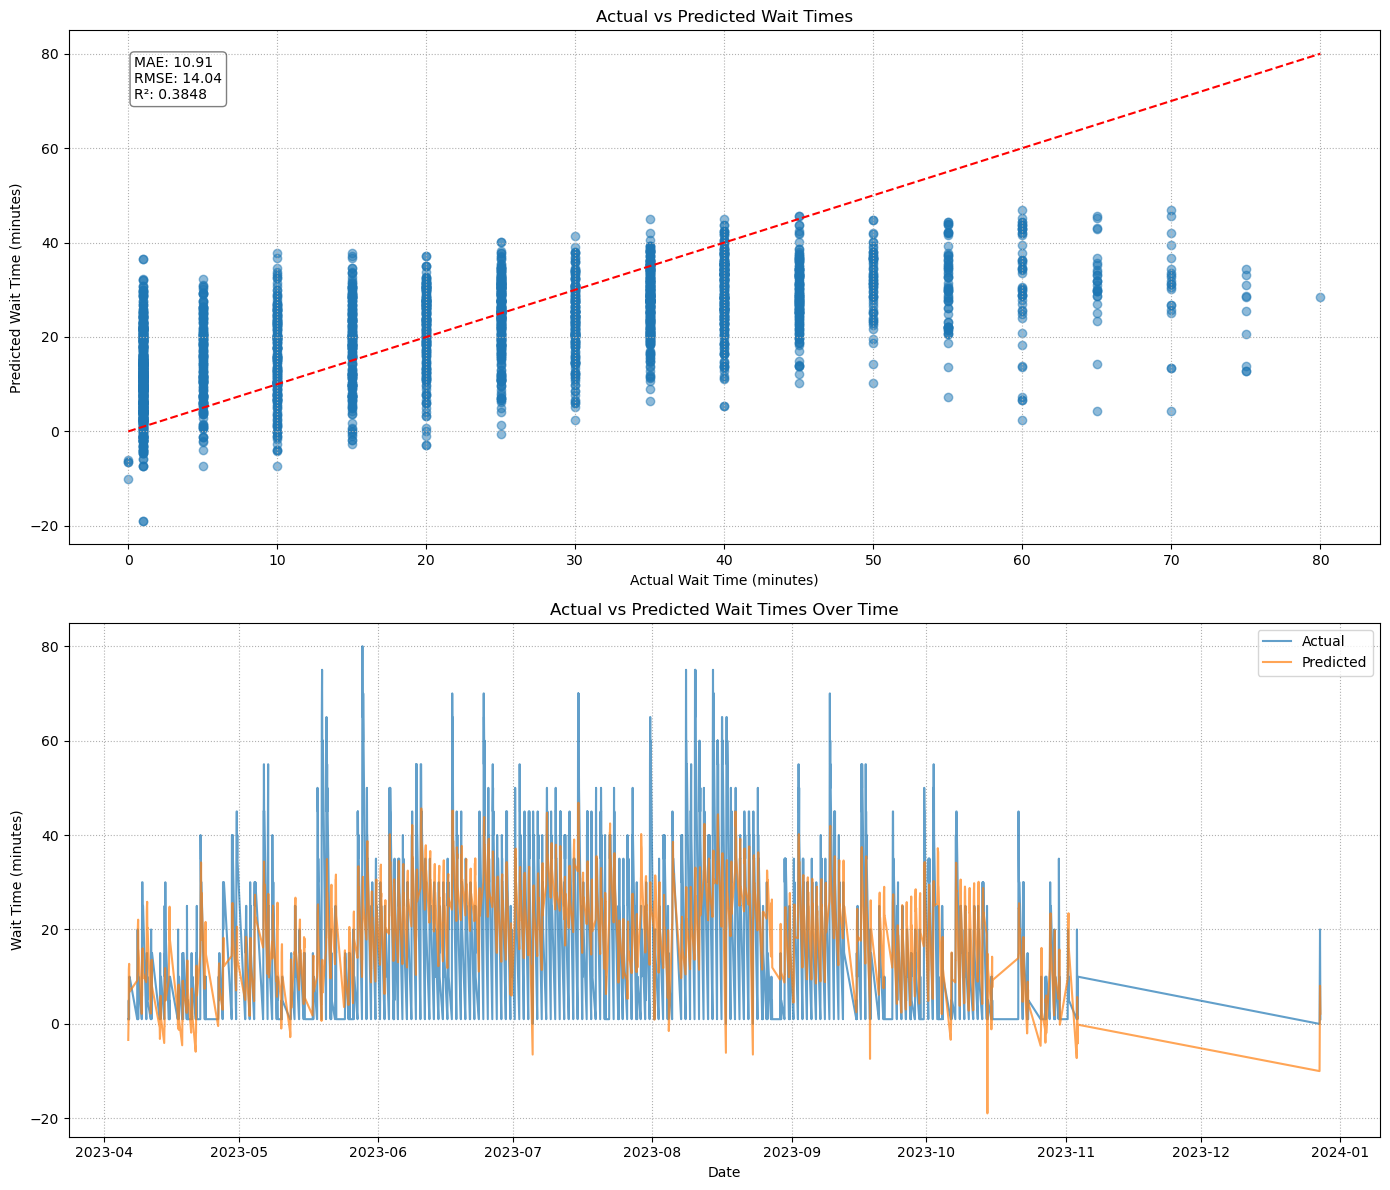

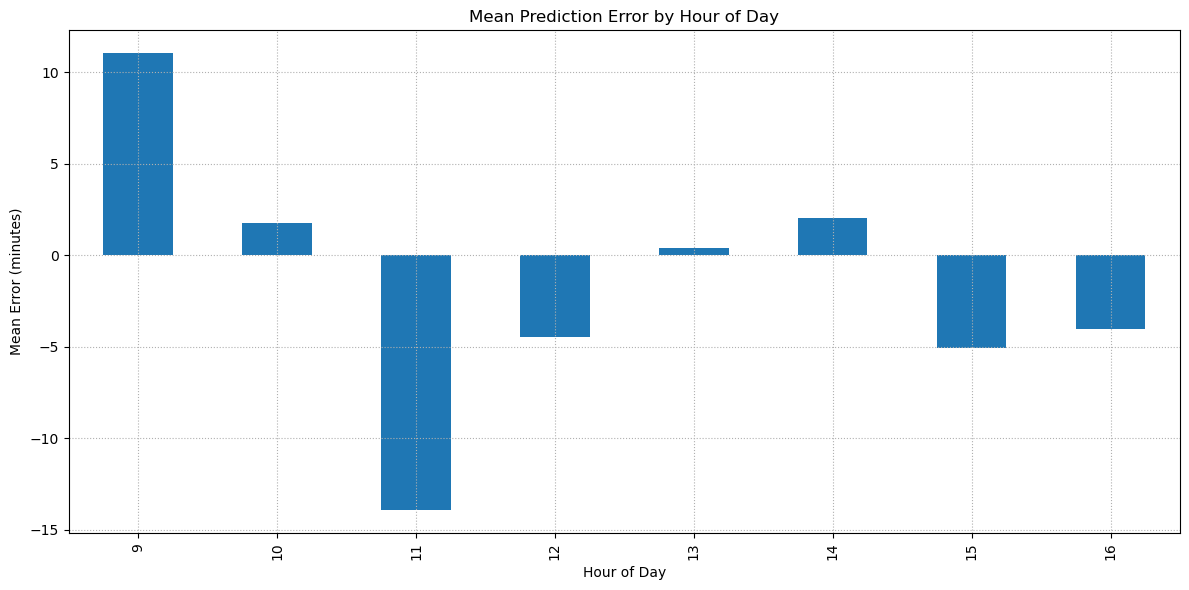

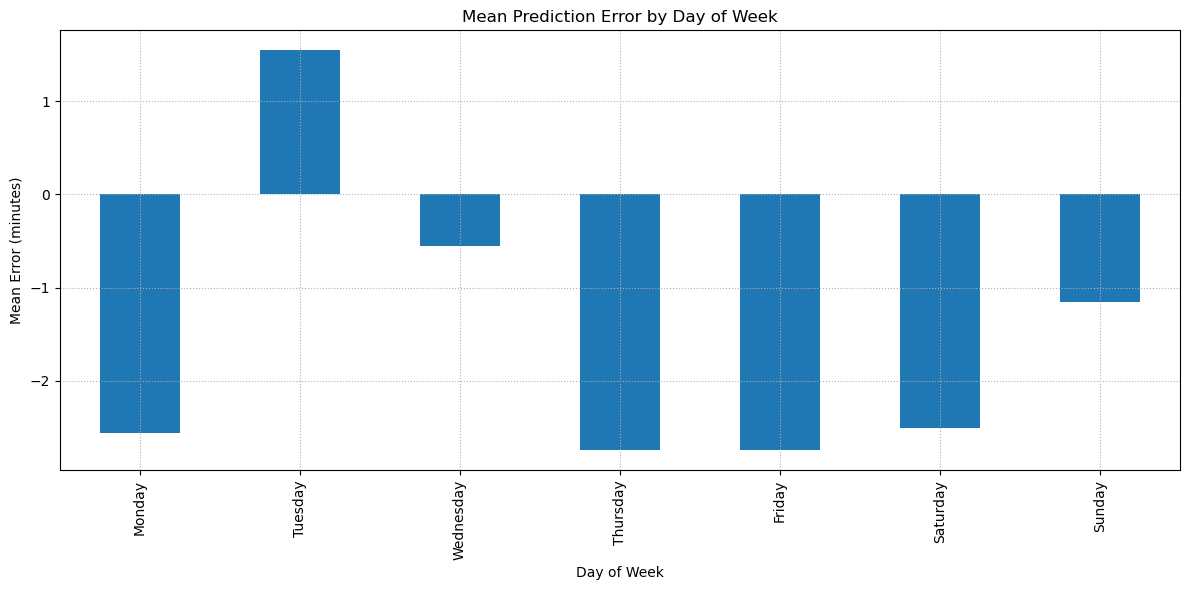

Model and metadata saved to models/linear\poseidon

Results Summary:


,ride_name,mae,rmse,r2,train_size,test_size
0,silver star,9.098347,11.884324,0.182617,21421,4018
2,poseidon,10.911152,14.043287,0.384765,16213,2893
1,blue fire megacoaster,11.702474,15.663934,0.189069,21299,4002


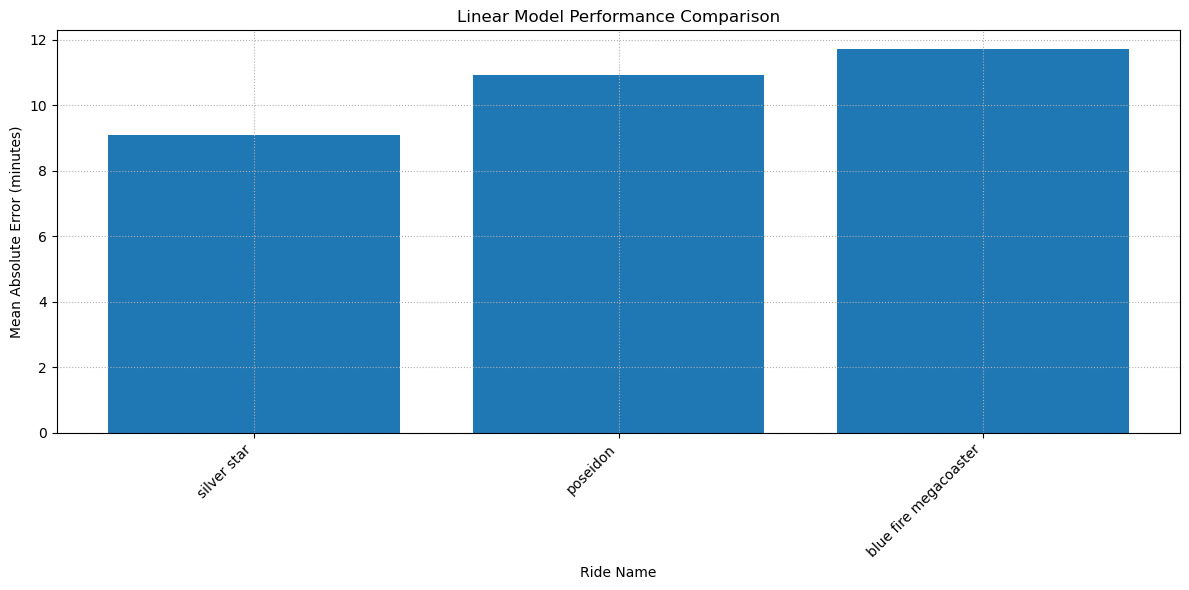

In [ ]:
def process_multiple_rides(data_path, ride_names=None, max_rides=5, test_year=2023):
    """Process multiple rides and compare their performance."""
    if not ride_names:
        full_data_sample = pd.read_parquet(data_path, columns=['ride_name']).drop_duplicates()
        ride_names = full_data_sample['ride_name'].unique().tolist()
        
        print(f"Discovered {len(ride_names)} rides in the dataset")

        ride_names = ride_names[:max_rides]
        
    results = []

    for ride_name in ride_names:
        try:
            print(f"\n{'='*50}")
            print(f"Processing ride: {ride_name}")
            print(f"{'='*50}")

            model, ride_df, ride_train_df, ride_test_df, predictions, cat_features, num_features = train_evaluate_linear_model(
                ride_name, 
                data_path, 
                test_year=test_year
            )

            mae = mean_absolute_error(ride_test_df['wait_time'], predictions)
            rmse = np.sqrt(mean_squared_error(ride_test_df['wait_time'], predictions))
            r2 = r2_score(ride_test_df['wait_time'], predictions)

            results.append({
                'ride_name': ride_name,
                'mae': mae,
                'rmse': rmse,
                'r2': r2,
                'train_size': len(ride_train_df),
                'test_size': len(ride_test_df)
            })

            metadata = {
                "ride_name": ride_name,
                "data_path": data_path,
                "train_size": len(ride_train_df),
                "test_size": len(ride_test_df),
                "metrics": {
                    "mae": float(mae),
                    "rmse": float(rmse),
                    "r2": float(r2)
                }
            }
            save_model(model, ride_name, metadata)
            
        except Exception as e:
            print(f"Error processing ride {ride_name}: {str(e)}")

    results_df = pd.DataFrame(results)

    if not results_df.empty:
        print("\nResults Summary:")
        results_df = results_df.sort_values('mae')
        display(results_df)

        plt.figure(figsize=(12, 6))
        plt.bar(results_df['ride_name'], results_df['mae'])
        plt.xlabel('Ride Name')
        plt.ylabel('Mean Absolute Error (minutes)')
        plt.title('Linear Model Performance Comparison')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, linestyle=':')
        plt.tight_layout()
        plt.show()
    
    return results_df

rides_to_process = ['silver star', 'eurosat', 'blue fire megacoaster', 'poseidon']
results_df = process_multiple_rides(data_path, rides_to_process)